In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# 定义 CNN 模型
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 超参数
batch_size = 128
lr = 0.001
epochs = 70

# 数据整理
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_dataset = torchvision.datasets.CIFAR10(root='Datasets', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='Datasets', train=False, download=True, transform=transform_test)

# 划分数据集
train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size
train_subset, valid_subset = random_split(train_dataset, [train_size, valid_size])

train_loader = DataLoader(dataset=train_subset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
train_data_size = len(train_subset)
valid_data_size = len(valid_subset)
test_data_size = len(test_dataset)

# 模型训练
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []
def train(num_epochs):
    for epoch in range(num_epochs):
        model.train()  # 切换到训练模式
        train_loss = 0.0
        train_acc = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            _, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            train_acc += acc.item() * images.size(0)
        
        valid_loss = 0.0
        valid_acc = 0.0
        with torch.no_grad():
            model.eval()  # 切换到验证模式
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item() * images.size(0)
                
                _, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))
                acc = torch.mean(correct_counts.type(torch.FloatTensor))
                valid_acc += acc.item() * images.size(0)
        
        avg_train_loss = train_loss / train_data_size
        avg_train_acc = train_acc / train_data_size
        avg_valid_loss = valid_loss / valid_data_size
        avg_valid_acc = valid_acc / valid_data_size

        print(
            f"Epoch [{epoch + 1}/{num_epochs}]"
            f" Training: Loss: {avg_train_loss:.4f}, Accuracy: {avg_train_acc * 100:.2f}%, "
            f"Validation: Loss: {avg_valid_loss:.4f}, Accuracy: {avg_valid_acc * 100:.2f}%"
        )
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_acc)
        valid_losses.append(avg_valid_loss)
        valid_accuracies.append(avg_valid_acc)
        
        

def test():
    model.eval()  # 切换到评估模式
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Accuracy: {100 * correct / total:.2f}%")

# 执行训练和评估
train(epochs)
test()

# 绘制损失曲线
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss_plt')
plt.legend()

# 绘制准确率曲线
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy_plt')
plt.legend()

plt.tight_layout()
plt.show()


Files already downloaded and verified
Files already downloaded and verified
Fold 1/5 :
Epoch [1/3] Training: Loss: 1.7565, Accuracy: 34.35%, Validation: Loss: 1.4989, Accuracy: 44.28%
Epoch [2/3] Training: Loss: 1.4282, Accuracy: 47.52%, Validation: Loss: 1.3186, Accuracy: 51.78%
Epoch [3/3] Training: Loss: 1.2448, Accuracy: 54.96%, Validation: Loss: 1.1458, Accuracy: 58.52%


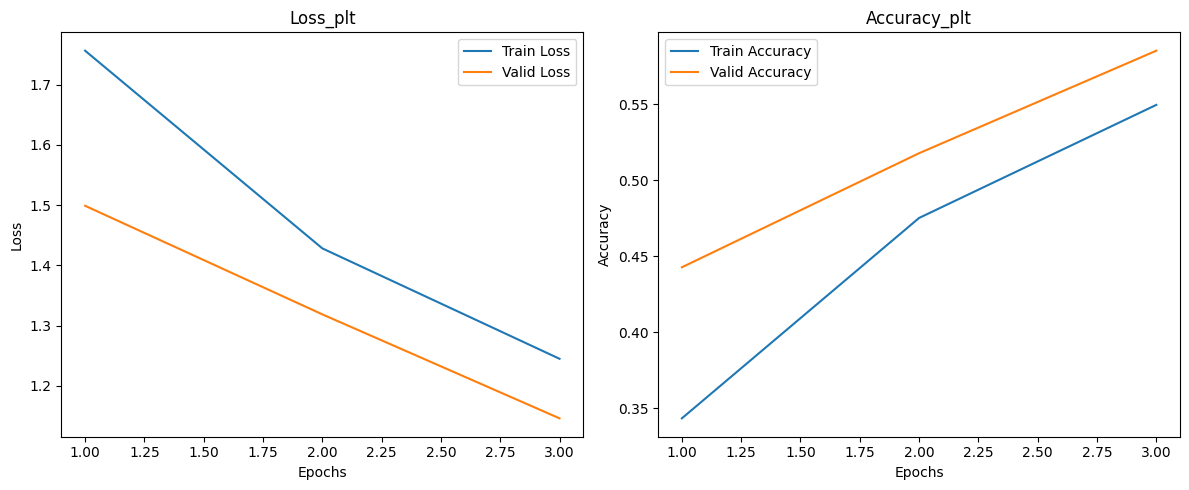

Fold 2/5 :
Epoch [1/3] Training: Loss: 1.7690, Accuracy: 33.66%, Validation: Loss: 1.4940, Accuracy: 43.94%
Epoch [2/3] Training: Loss: 1.4378, Accuracy: 47.00%, Validation: Loss: 1.2905, Accuracy: 51.43%
Epoch [3/3] Training: Loss: 1.2747, Accuracy: 53.80%, Validation: Loss: 1.1583, Accuracy: 58.25%


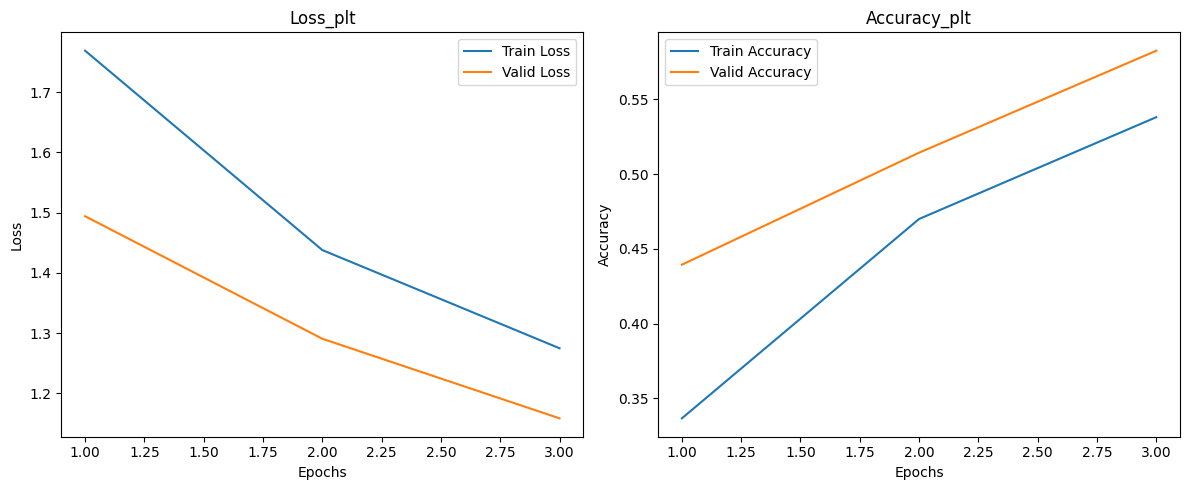

Fold 3/5 :
Epoch [1/3] Training: Loss: 1.7810, Accuracy: 33.26%, Validation: Loss: 1.4421, Accuracy: 46.45%
Epoch [2/3] Training: Loss: 1.4232, Accuracy: 47.90%, Validation: Loss: 1.2355, Accuracy: 55.05%
Epoch [3/3] Training: Loss: 1.2533, Accuracy: 54.48%, Validation: Loss: 1.1608, Accuracy: 58.49%


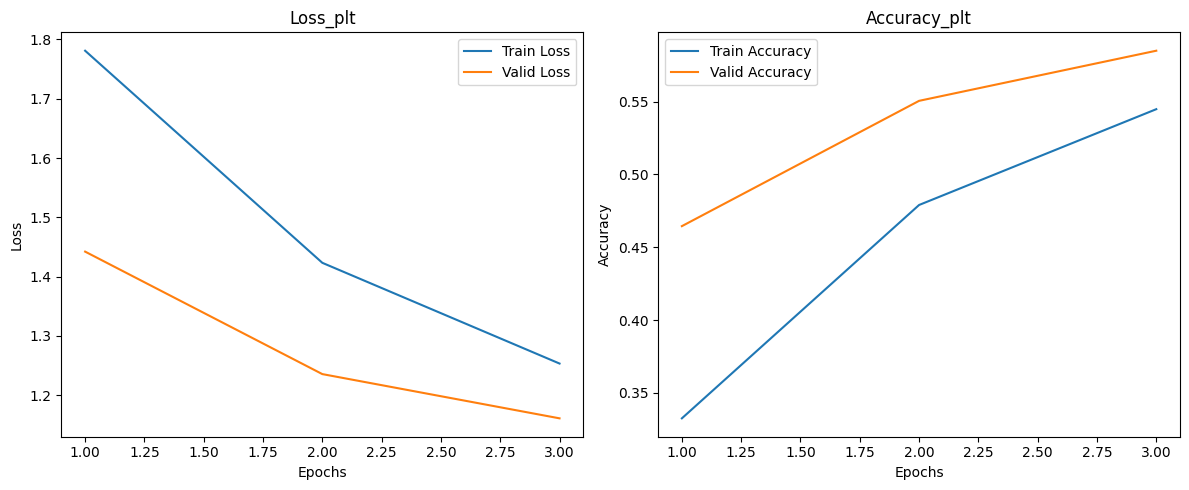

Fold 4/5 :
Epoch [1/3] Training: Loss: 1.7869, Accuracy: 32.80%, Validation: Loss: 1.4920, Accuracy: 44.51%
Epoch [2/3] Training: Loss: 1.4215, Accuracy: 47.77%, Validation: Loss: 1.3080, Accuracy: 52.03%
Epoch [3/3] Training: Loss: 1.2336, Accuracy: 55.53%, Validation: Loss: 1.1819, Accuracy: 57.93%


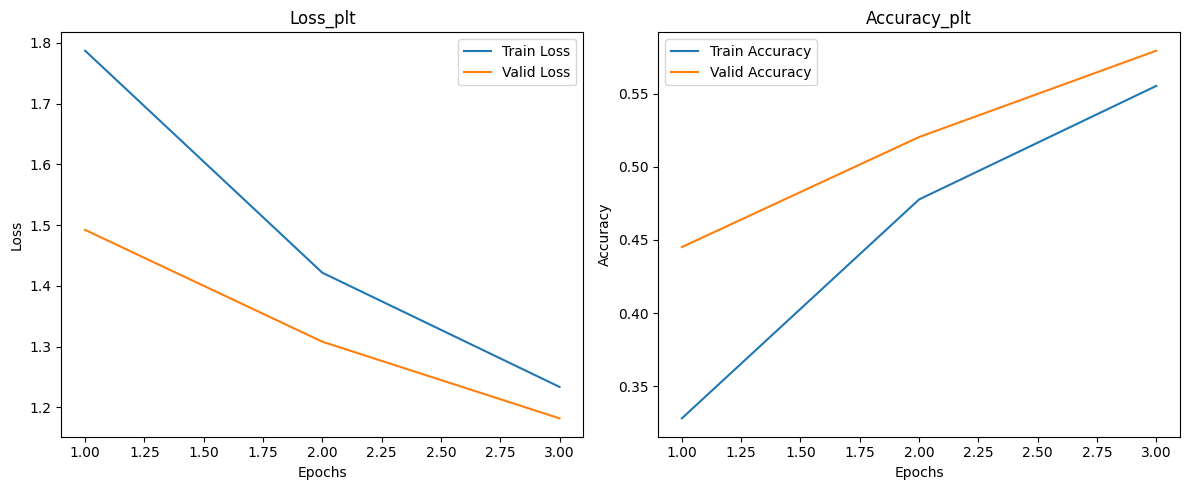

Fold 5/5 :
Epoch [1/3] Training: Loss: 1.7574, Accuracy: 34.30%, Validation: Loss: 1.4865, Accuracy: 44.46%
Epoch [2/3] Training: Loss: 1.4219, Accuracy: 47.77%, Validation: Loss: 1.2420, Accuracy: 54.59%
Epoch [3/3] Training: Loss: 1.2474, Accuracy: 54.74%, Validation: Loss: 1.1466, Accuracy: 58.44%


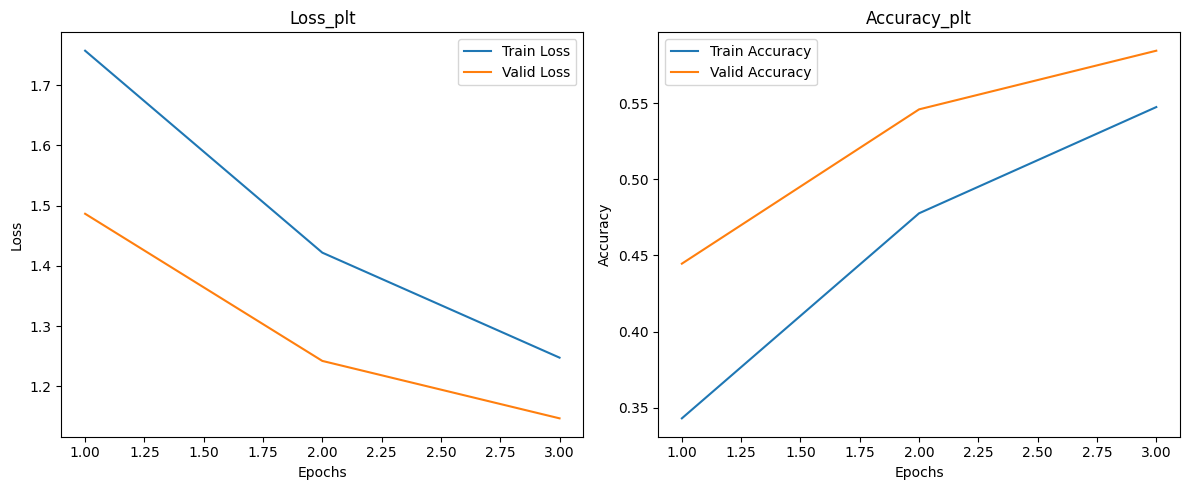

k-fold average Train Accuracy: 54.70%
k-fold average Validation Accuracy: 58.33%
Test Accuracy: 61.92%


In [5]:
# 5折验证
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 定义 CNN 模型
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 超参数
batch_size = 128
lr = 0.001
epochs = 3

# 数据整理
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_dataset = torchvision.datasets.CIFAR10(root='Datasets', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='Datasets', train=False, download=True, transform=transform_test)

# # 划分数据集
# train_size = int(0.8 * len(train_dataset))
# valid_size = len(train_dataset) - train_size
# train_subset, valid_subset = random_split(train_dataset, [train_size, valid_size])

# train_loader = DataLoader(dataset=train_subset, batch_size=batch_size, shuffle=True)
# valid_loader = DataLoader(dataset=valid_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# train_data_size = len(train_subset)
# valid_data_size = len(valid_subset)
test_data_size = len(test_dataset)

# K折交叉验证设置
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True)
fold_train_accuracies = [] # 初始化保存每折的结果
fold_valid_accuracies = []

# 模型训练
def train(num_epochs):
    for epoch in range(num_epochs):
        model.train()  # 切换到训练模式
        train_loss = 0.0
        train_acc = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            _, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            train_acc += acc.item() * images.size(0)
        
        valid_loss = 0.0
        valid_acc = 0.0
        with torch.no_grad():
            model.eval()  # 切换到验证模式
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item() * images.size(0)
                
                _, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))
                acc = torch.mean(correct_counts.type(torch.FloatTensor))
                valid_acc += acc.item() * images.size(0)
        
        avg_train_loss = train_loss / train_data_size
        avg_train_acc = train_acc / train_data_size
        avg_valid_loss = valid_loss / valid_data_size
        avg_valid_acc = valid_acc / valid_data_size

        # print(
        #     f"Epoch [{epoch + 1}/{num_epochs}]"
        #     f" Training: Loss: {avg_train_loss:.4f}, Accuracy: {avg_train_acc * 100:.2f}%, "
        #     f"Validation: Loss: {avg_valid_loss:.4f}, Accuracy: {avg_valid_acc * 100:.2f}%"
        # )
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_acc)
        valid_losses.append(avg_valid_loss)
        valid_accuracies.append(avg_valid_acc)
        
    return avg_train_acc, avg_valid_acc

# 绘图函数        
def PLT(epochs, train_losses, valid_losses, train_accuracies, valid_accuracies):
    # 绘制损失曲线
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs + 1), valid_losses, label='Valid Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss_plt')
    plt.legend()

    # 绘制准确率曲线
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, epochs + 1), valid_accuracies, label='Valid Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy_plt')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 5折交叉验证
for fold, (train_idx, valid_idx) in enumerate(kf.split(train_dataset)):
    print(f"Fold {fold + 1}/{k_folds} :")
    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []
    # 构造每折的训练和验证数据
    train_subset = torch.utils.data.Subset(train_dataset, train_idx)
    valid_subset = torch.utils.data.Subset(train_dataset, valid_idx)
    train_data_size = len(train_subset)
    valid_data_size = len(valid_subset)
    test_data_size = len(test_dataset)
    train_loader = DataLoader(dataset=train_subset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(dataset=valid_subset, batch_size=batch_size, shuffle=False)

    # 初始化模型、优化器
    model = SimpleCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # 开始训练
    avg_train_acc, avg_valid_acc = train(epochs)

    # 保存每折的验证准确率
    fold_train_accuracies.append(train_accuracies[-1])  # 取最后一轮的准确率
    fold_valid_accuracies.append(valid_accuracies[-1])
    print(f"Fold: Train Accuracy: {avg_train_acc * 100:.2f}%, Validation Accuracy: {avg_valid_acc * 100:.2f}%")
    
    PLT(epochs,train_losses, valid_losses, train_accuracies, valid_accuracies)
    

# 计算最终的平均准确率
avg_train_accuracy = np.mean(fold_train_accuracies)
avg_valid_accuracy = np.mean(fold_valid_accuracies)
print(f"k-fold average Train Accuracy: {avg_train_accuracy * 100:.2f}%")
print(f"k-fold average Validation Accuracy: {avg_valid_accuracy * 100:.2f}%")
        

def test():
    model.eval()  # 切换到评估模式
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Accuracy: {100 * correct / total:.2f}%")

# 执行训练和评估
test()




ssh -p 16393 root@region-41.seetacloud.com


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold

# 定义 CNN 模型
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 数据整理
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

dataset = torchvision.datasets.CIFAR10(root='Datasets', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='Datasets', train=False, download=True, transform=transform_test)

# 超参数范围
param_grid = {
    'batch_size': [64, 128],
    'lr': [0.001, 0.0005],
    'epochs': [2, 3]
}

best_params = None
best_valid_acc = 0

# 交叉验证
for batch_size in param_grid['batch_size']:
    for lr in param_grid['lr']:
        for epochs in param_grid['epochs']:
            print(f"Training with batch_size={batch_size}, lr={lr}, epochs={epochs}")
            
            # 使用 KFold 进行交叉验证
            kf = KFold(n_splits=2, shuffle=True)
            fold_valid_accuracies = []

            for train_idx, valid_idx in kf.split(dataset):
                train_subset = torch.utils.data.Subset(dataset, train_idx)
                valid_subset = torch.utils.data.Subset(dataset, valid_idx)

                train_loader = DataLoader(dataset=train_subset, batch_size=batch_size, shuffle=True)
                valid_loader = DataLoader(dataset=valid_subset, batch_size=batch_size, shuffle=False)

                # 模型、损失函数、优化器
                model = SimpleCNN().to(device)
                criterion = nn.CrossEntropyLoss()
                optimizer = optim.Adam(model.parameters(), lr=lr)

                for epoch in range(epochs):
                    model.train()  # 切换到训练模式
                    train_loss = 0.0
                    train_acc = 0.0

                    for images, labels in train_loader:
                        images, labels = images.to(device), labels.to(device)
                        optimizer.zero_grad()
                        outputs = model(images)
                        loss = criterion(outputs, labels)
                        loss.backward()
                        optimizer.step()
                        
                        train_loss += loss.item() * images.size(0)
                        _, predictions = torch.max(outputs.data, 1)
                        correct_counts = predictions.eq(labels.data.view_as(predictions))
                        acc = torch.mean(correct_counts.type(torch.FloatTensor))
                        train_acc += acc.item() * images.size(0)
                    
                    valid_loss = 0.0
                    valid_acc = 0.0
                    with torch.no_grad():
                        model.eval()  # 切换到验证模式
                        for images, labels in valid_loader:
                            images, labels = images.to(device), labels.to(device)
                            outputs = model(images)
                            loss = criterion(outputs, labels)
                            valid_loss += loss.item() * images.size(0)
                            
                            _, predictions = torch.max(outputs.data, 1)
                            correct_counts = predictions.eq(labels.data.view_as(predictions))
                            acc = torch.mean(correct_counts.type(torch.FloatTensor))
                            valid_acc += acc.item() * images.size(0)

                    avg_train_acc = train_acc / len(train_subset)
                    avg_valid_acc = valid_acc / len(valid_subset)

                print(f"Fold: Train Accuracy: {avg_train_acc * 100:.2f}%, Validation Accuracy: {avg_valid_acc * 100:.2f}%")
                fold_valid_accuracies.append(avg_valid_acc)

            mean_valid_acc = np.mean(fold_valid_accuracies)
            print(f"Mean Validation Accuracy for batch_size={batch_size}, lr={lr}, epochs={epochs}: {mean_valid_acc * 100:.2f}%")

            # 更新最佳参数
            if mean_valid_acc > best_valid_acc:
                best_valid_acc = mean_valid_acc
                best_params = (batch_size, lr, epochs)

print(f"Best Params: Batch Size={best_params[0]}, Learning Rate={best_params[1]}, Epochs={best_params[2]} with Validation Accuracy={best_valid_acc * 100:.2f}%")

# 使用最佳超参数重新训练模型
best_batch_size, best_lr, best_epochs = best_params

train_loader = DataLoader(dataset=dataset, batch_size=best_batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_subset, batch_size=best_batch_size, shuffle=False)

# 重新训练模型
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=best_lr)

# 训练并评估
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []

for epoch in range(best_epochs):
    model.train()  # 切换到训练模式
    train_loss = 0.0
    train_acc = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
        _, predictions = torch.max(outputs.data, 1)
        correct_counts = predictions.eq(labels.data.view_as(predictions))
        acc = torch.mean(correct_counts.type(torch.FloatTensor))
        train_acc += acc.item() * images.size(0)

    valid_loss = 0.0
    valid_acc = 0.0
    with torch.no_grad():
        model.eval()  # 切换到验证模式
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * images.size(0)
            
            _, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            valid_acc += acc.item() * images.size(0)

    avg_train_acc = train_acc / len(dataset)
    avg_valid_acc = valid_acc / len(valid_subset)

    print(f"Epoch [{epoch + 1}/{best_epochs}] - Train Accuracy: {avg_train_acc * 100:.2f}%, Validation Accuracy: {avg_valid_acc * 100:.2f}%")

# 测试
def test():
    model.eval()  # 切换到评估模式
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Accuracy: {100 * correct / total:.2f}%")

test()


Files already downloaded and verified
Files already downloaded and verified
Training with batch_size=64, lr=0.001, epochs=2
Fold: Train Accuracy: 44.58%, Validation Accuracy: 48.42%
Fold: Train Accuracy: 45.03%, Validation Accuracy: 49.84%
Mean Validation Accuracy for batch_size=64, lr=0.001, epochs=2: 49.13%
Training with batch_size=64, lr=0.001, epochs=3
Fold: Train Accuracy: 50.66%, Validation Accuracy: 53.88%
Fold: Train Accuracy: 50.54%, Validation Accuracy: 55.04%
Mean Validation Accuracy for batch_size=64, lr=0.001, epochs=3: 54.46%
Training with batch_size=64, lr=0.0005, epochs=2
Fold: Train Accuracy: 42.15%, Validation Accuracy: 46.00%
Fold: Train Accuracy: 42.06%, Validation Accuracy: 45.22%
Mean Validation Accuracy for batch_size=64, lr=0.0005, epochs=2: 45.61%
Training with batch_size=64, lr=0.0005, epochs=3
Fold: Train Accuracy: 48.18%, Validation Accuracy: 50.43%
Fold: Train Accuracy: 47.30%, Validation Accuracy: 52.51%
Mean Validation Accuracy for batch_size=64, lr=0.000

Files already downloaded and verified
Files already downloaded and verified
Training with batch_size=64, lr=0.005, epochs=70
Fold 1: Train Accuracy: 78.01%, Validation Accuracy: 71.76%
Fold 2: Train Accuracy: 74.57%, Validation Accuracy: 71.36%
Fold 3: Train Accuracy: 77.90%, Validation Accuracy: 72.12%
Fold 4: Train Accuracy: 76.31%, Validation Accuracy: 73.92%
Fold 5: Train Accuracy: 80.59%, Validation Accuracy: 75.28%
Mean Validation Accuracy for batch_size=64, lr=0.005, epochs=70: 72.89%
-------------------------------------------------------------------
Training with batch_size=64, lr=0.001, epochs=70
Fold 1: Train Accuracy: 95.98%, Validation Accuracy: 81.04%
Fold 2: Train Accuracy: 95.60%, Validation Accuracy: 80.64%
Fold 3: Train Accuracy: 96.35%, Validation Accuracy: 80.64%
Fold 4: Train Accuracy: 95.93%, Validation Accuracy: 81.04%
Fold 5: Train Accuracy: 95.70%, Validation Accuracy: 82.92%
Mean Validation Accuracy for batch_size=64, lr=0.001, epochs=70: 81.26%
--------------

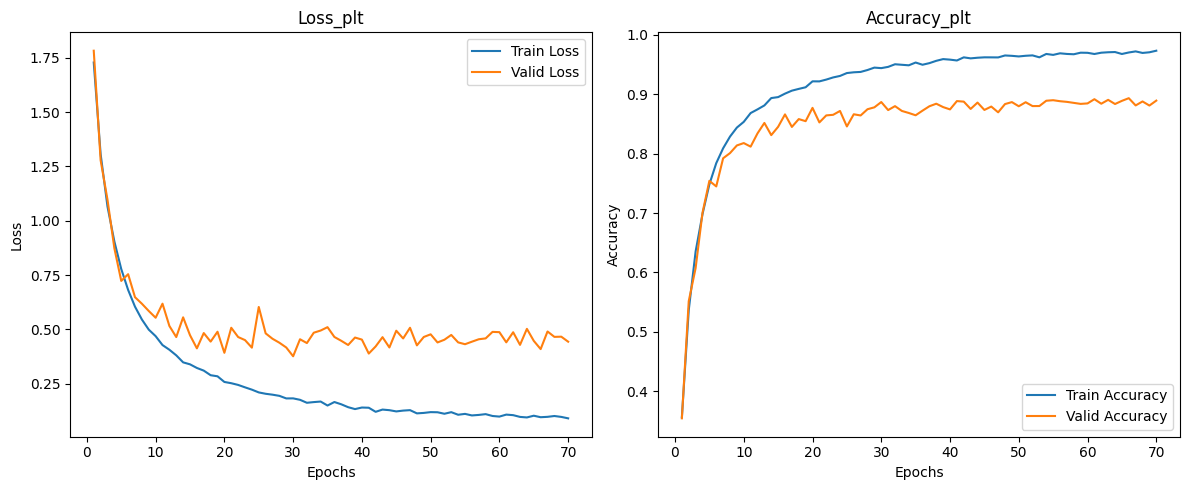

Test Accuracy: 88.40%
All Time: 284 分 2 秒


In [12]:
# 交叉验证调参
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
import time

# 残差块
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)  
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)  # 添加归一化层
        
        # 用于调整输入和输出的维度
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)  # 应用归一化
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)  # 应用归一化
        return self.relu(out + self.shortcut(x))  # 残差

# 带有残差连接的 AlexNet 模型
class RRRR(nn.Module):
    def __init__(self):
        super(RRRR, self).__init__()
        self.features = nn.Sequential(
            ResidualBlock(3, 64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResidualBlock(64, 192),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResidualBlock(192, 384),
            ResidualBlock(384, 256),
            ResidualBlock(256, 256),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.AdaptiveAvgPool2d((1, 1))  # 使用自适应平均池化
        )
        self.classifier = nn.Sequential(
            nn.Linear(256, 64),  # 修改全连接层输入尺寸
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),  # 添加 dropout 层
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256)  # 修改展平后的尺寸
        x = self.classifier(x)
        return x

# 数据整理
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

dataset = torchvision.datasets.CIFAR10(root='Datasets', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='Datasets', train=False, download=True, transform=transform_test)

# 超参数网格
param_grid = {
    'batch_size': [64, 128, 256],
    'lr': [0.005, 0.001, 0.0005],
    'epochs': [70]
}

best_params = None
best_valid_acc = 0

def train(num_epochs):
    for epoch in range(num_epochs):
        model.train()  # 切换到训练模式
        train_loss = 0.0
        train_acc = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            _, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            train_acc += acc.item() * images.size(0)
        
        valid_loss = 0.0
        valid_acc = 0.0
        with torch.no_grad():
            model.eval()  # 切换到验证模式
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item() * images.size(0)
                
                _, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))
                acc = torch.mean(correct_counts.type(torch.FloatTensor))
                valid_acc += acc.item() * images.size(0)
        
        avg_train_loss = train_loss / len(train_subset)
        avg_train_acc = train_acc / len(train_subset)
        avg_valid_loss = valid_loss / len(valid_subset)
        avg_valid_acc = valid_acc / len(valid_subset)

        # print(
        #     f"Epoch [{epoch + 1}/{num_epochs}]"
        #     f" Training: Loss: {avg_train_loss:.4f}, Accuracy: {avg_train_acc * 100:.2f}%, "
        #     f"Validation: Loss: {avg_valid_loss:.4f}, Accuracy: {avg_valid_acc * 100:.2f}%"
        # )
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_acc)
        valid_losses.append(avg_valid_loss)
        valid_accuracies.append(avg_valid_acc)
    return avg_train_acc, avg_valid_acc

def PLT(epochs, train_losses, valid_losses, train_accuracies, valid_accuracies):
    # 绘制损失曲线
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs + 1), valid_losses, label='Valid Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss_plt')
    plt.legend()

    # 绘制准确率曲线
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, epochs + 1), valid_accuracies, label='Valid Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy_plt')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 使用一部分训练集，降低计算成本
subset_size = int(0.25 * len(dataset))
_, sampled_dataset = random_split(dataset, [len(dataset) - subset_size, subset_size])

# 交叉验证
for batch_size in param_grid['batch_size']:
    for lr in param_grid['lr']:
        for epochs in param_grid['epochs']:
            print(f"Training with batch_size={batch_size}, lr={lr}, epochs={epochs}")
            
            # 使用 KFold 进行交叉验证
            kf = KFold(n_splits=5, shuffle=True)
            fold_valid_accuracies = []

            for fold, (train_idx, valid_idx) in enumerate(kf.split(sampled_dataset)):
                # print(f"Fold {fold + 1}/{k_folds} :")
                train_losses, valid_losses = [], []
                train_accuracies, valid_accuracies = [], []
                
                train_subset = torch.utils.data.Subset(sampled_dataset, train_idx)
                valid_subset = torch.utils.data.Subset(sampled_dataset, valid_idx)

                train_loader = DataLoader(dataset=train_subset, batch_size=batch_size, shuffle=True)
                valid_loader = DataLoader(dataset=valid_subset, batch_size=batch_size, shuffle=False)

                # 模型、损失函数、优化器
                model = RRRR().to(device)
                criterion = nn.CrossEntropyLoss()
                optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
                
                # 调用训练函数，返回该折结果
                avg_train_acc, avg_valid_acc = train(epochs)
                
                # 打印该折的精度
                print(f"Fold {fold + 1}: Train Accuracy: {avg_train_acc * 100:.2f}%, Validation Accuracy: {avg_valid_acc * 100:.2f}%")
                # 绘制该折的曲线
                # PLT(epochs,train_losses, valid_losses, train_accuracies, valid_accuracies)
                fold_valid_accuracies.append(avg_valid_acc)

            mean_valid_acc = np.mean(fold_valid_accuracies)
            print(f"Mean Validation Accuracy for batch_size={batch_size}, lr={lr}, epochs={epochs}: {mean_valid_acc * 100:.2f}%")
            print("-------------------------------------------------------------------")

            # 更新最佳参数
            if mean_valid_acc > best_valid_acc:
                best_valid_acc = mean_valid_acc
                best_params = (batch_size, lr, epochs)

print(f"Best Params: Batch Size={best_params[0]}, Learning Rate={best_params[1]}, Epochs={best_params[2]} with Validation Accuracy={best_valid_acc * 100:.2f}%")

# 使用最佳超参数重新训练模型
best_batch_size, best_lr, best_epochs = best_params

# train_loader = DataLoader(dataset=dataset, batch_size=best_batch_size, shuffle=True)
# valid_loader = DataLoader(dataset=valid_subset, batch_size=best_batch_size, shuffle=False)
# 使用完整数据集重新划分
train_size = int(0.8 * len(dataset))
valid_size = len(train_dataset) - train_size
t_subset, v_subset = random_split(train_dataset, [train_size, valid_size])

train_loader = DataLoader(dataset=t_subset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=v_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 重新训练模型
model = RRRR().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=best_lr, weight_decay=1e-4) # 启用权重衰退

# 画图参数
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []

for epoch in range(best_epochs):
    model.train()  # 切换到训练模式
    train_loss = 0.0
    train_acc = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
        _, predictions = torch.max(outputs.data, 1)
        correct_counts = predictions.eq(labels.data.view_as(predictions))
        acc = torch.mean(correct_counts.type(torch.FloatTensor))
        train_acc += acc.item() * images.size(0)
    
    valid_loss = 0.0
    valid_acc = 0.0
    with torch.no_grad():
        model.eval()  # 切换到验证模式
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * images.size(0)
            
            _, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            valid_acc += acc.item() * images.size(0)
    
    avg_train_loss = train_loss / train_size  # 改为重新划分的大小
    avg_train_acc = train_acc / train_size
    avg_valid_loss = valid_loss / valid_size
    avg_valid_acc = valid_acc / valid_size

    # print(
    #     f"Epoch [{epoch + 1}/{num_epochs}]"
    #     f" Training: Loss: {avg_train_loss:.4f}, Accuracy: {avg_train_acc * 100:.2f}%, "
    #     f"Validation: Loss: {avg_valid_loss:.4f}, Accuracy: {avg_valid_acc * 100:.2f}%"
    # )
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)
    valid_losses.append(avg_valid_loss)
    valid_accuracies.append(avg_valid_acc)
print(f"Best model performance: Train Accuracy: {avg_train_acc * 100:.2f}%, Validation Accuracy: {avg_valid_acc * 100:.2f}%")
print("-------------------------------------------------------------------")
# 绘画出来
PLT(best_epochs, train_losses, valid_losses, train_accuracies, valid_accuracies)

# 测试
def test():
    model.eval()  # 切换到评估模式
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Accuracy: {100 * correct / total:.2f}%")

test()
all_end = time.time() # 计时结束
all_time = round(all_end - all_start)
print("All Time: {:d} 分 {:d} 秒".format(all_time // 60, all_time % 60))

In [9]:
# 基于Alex改造的resnet + dropout! + bn + weight decay(Adam) + 进一步减轻全连接 + 采用自适应池化
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import time

# 残差块
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)  
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)  # 添加归一化层
        
        # 用于调整输入和输出的维度
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)  # 应用归一化
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)  # 应用归一化
        return self.relu(out + self.shortcut(x))  # 残差

# 带有残差连接的 AlexNet 模型
class RRRR(nn.Module):
    def __init__(self):
        super(RRRR, self).__init__()
        self.features = nn.Sequential(
            ResidualBlock(3, 64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResidualBlock(64, 192),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResidualBlock(192, 384),
            ResidualBlock(384, 256),
            ResidualBlock(256, 256),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.AdaptiveAvgPool2d((1, 1))  # 使用自适应平均池化
        )
        self.classifier = nn.Sequential(
            nn.Linear(256, 64),  # 修改全连接层输入尺寸
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),  # 添加 dropout 层
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256)  # 修改展平后的尺寸
        x = self.classifier(x)
        return x
# 超参数
batch_size = 128
lr = 0.001
epochs = 70

# 数据整理
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) 
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_dataset = torchvision.datasets.CIFAR10(root='Datasets', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='Datasets', train=False, download=True, transform=transform_test)
subset_size = int(0.25 * len(train_dataset))
_, sampled_dataset = random_split(train_dataset, [len(train_dataset) - subset_size, subset_size])


# 划分数据集
train_size = int(0.8 * len(sampled_dataset))
valid_size = len(sampled_dataset) - train_size
train_subset, valid_subset = random_split(sampled_dataset, [train_size, valid_size])

train_loader = DataLoader(dataset=train_subset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
train_data_size = len(train_subset)
valid_data_size = len(valid_subset)
test_data_size = len(test_dataset)

# 模型训练

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RRRR().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr,  weight_decay=1e-4)
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []
def train(num_epochs):
    for epoch in range(num_epochs):
        model.train()  # 切换到训练模式
        train_loss = 0.0
        train_acc = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            _, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            train_acc += acc.item() * images.size(0)
        
        valid_loss = 0.0
        valid_acc = 0.0
        with torch.no_grad():
            model.eval()  # 切换到验证模式
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item() * images.size(0)
                
                _, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))
                acc = torch.mean(correct_counts.type(torch.FloatTensor))
                valid_acc += acc.item() * images.size(0)
        
        avg_train_loss = train_loss / train_data_size
        avg_train_acc = train_acc / train_data_size
        avg_valid_loss = valid_loss / valid_data_size
        avg_valid_acc = valid_acc / valid_data_size

        print(
            f"Epoch [{epoch + 1}/{num_epochs}]"
            f" Training: Loss: {avg_train_loss:.4f}, Accuracy: {avg_train_acc * 100:.2f}%, "
            f"Validation: Loss: {avg_valid_loss:.4f}, Accuracy: {avg_valid_acc * 100:.2f}%"
        )
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_acc)
        valid_losses.append(avg_valid_loss)
        valid_accuracies.append(avg_valid_acc)
        
        

def test():
    model.eval()  # 切换到评估模式
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Accuracy: {100 * correct / total:.2f}%")

# 执行训练和评估
all_start = time.time() # 计时
train(epochs)
test()
all_end = time.time() # 计时结束
all_time = round(all_end - all_start)
print("All Time: {:d} 分 {:d} 秒".format(all_time // 60, all_time % 60))

# 绘制损失曲线
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss_plt')
plt.legend()

# 绘制准确率曲线
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy_plt')
plt.legend()

plt.tight_layout()
plt.show()

Files already downloaded and verified
Files already downloaded and verified
Epoch [1/70] Training: Loss: 1.9930, Accuracy: 24.18%, Validation: Loss: 1.8279, Accuracy: 27.96%
Epoch [2/70] Training: Loss: 1.7427, Accuracy: 32.94%, Validation: Loss: 1.5892, Accuracy: 40.00%
Epoch [3/70] Training: Loss: 1.5609, Accuracy: 40.94%, Validation: Loss: 1.4921, Accuracy: 42.52%
Epoch [4/70] Training: Loss: 1.4668, Accuracy: 45.40%, Validation: Loss: 1.4633, Accuracy: 45.52%
Epoch [5/70] Training: Loss: 1.3676, Accuracy: 50.84%, Validation: Loss: 1.4083, Accuracy: 49.52%
Epoch [6/70] Training: Loss: 1.2978, Accuracy: 53.07%, Validation: Loss: 1.2376, Accuracy: 55.64%
Epoch [7/70] Training: Loss: 1.1996, Accuracy: 58.01%, Validation: Loss: 1.2554, Accuracy: 54.60%
Epoch [8/70] Training: Loss: 1.1416, Accuracy: 60.42%, Validation: Loss: 1.1909, Accuracy: 56.20%
Epoch [9/70] Training: Loss: 1.0667, Accuracy: 63.37%, Validation: Loss: 1.0999, Accuracy: 58.84%
Epoch [10/70] Training: Loss: 0.9834, Accu

KeyboardInterrupt: 